<div id="header" align="center">
 <h1>  Модель оттока клиентов телекоммуникационной компании</h1>
</div>

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Цель работы:** Построить модель оттока с показателем  AUC-ROC не менее 0.85.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных:**

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Информация о договорах актуальна на 1 февраля 2020.

Описание данных в датафреймах:

*Информация о договорах:*
- customerID - уникальный код клиента,
- BeginDate - дата заключения договора,
- EndDate - дата расторжения договора,
- Type - периодичность оплаты,
- PaperlessBilling - безбумажное выставление счетов,
- PaymentMethod - метод оплаты услуг,
- MonthlyCharges - ежемесячные платежи,
- TotalCharges - общая сумма платежей.

*Информация о клиентах:*
- customerID - уникальный код клиента,
- gender - пол клиента,
- SeniorCitizen - является ли клиент пенсионером,
- Partner - состоит ли клиент в браке,
- Dependents - наличие иждивенцев.

*Информация об интернет-услугах:*
- customerID - уникальный код клиента,
- InternetService - тип подключения интернету,
- OnlineSecurity - наличие блокировки небезопасных сайтов,
- OnlineBackup - наличие облачного хранилища файлов,
- DeviceProtection - наличие антивируса,
- TechSupport - наличие выделенной линии технической поддержки,
- StreamingTV - наличие стримингового телевидения,
- StreamingMovies - наличие услуги Каталог фильмов.

*Информация об услугах телефонии:*
- customerID - уникальный код клиента,
- MultipleLines - наличие нескольких телефонных линий.

## 1. Загрузка и общий обзор данных

Импортируем библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler 

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

from sklearn.metrics import roc_curve, roc_auc_score, make_scorer

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.mode.chained_assignment = None

Загрузим данные, сохраним их в 4 датафрема:

In [3]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

Выгрузим основную информацию о датафреймах, первые 5 строк и размер:

In [4]:
for frame in [contract, personal, internet, phone]:
    print(f'Размер датафрейма: {frame.shape}\n')
    display(frame.info())
    display(frame.head())
    print('_________________\n')

Размер датафрейма: (7043, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


_________________

Размер датафрейма: (7043, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


_________________

Размер датафрейма: (5517, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


_________________

Размер датафрейма: (6361, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


_________________



**Вывод**

Таблицы с данными о договорах и клиентах содержат по 7043 записей. Информация об интернет-услугах содержит 5517 записей. 
Информация об услугах телефонии содержит 6361 записей. Значит, есть клиенты, которые пользуются только услугами телефонии, есть клиенты, которые пользуются только интернет-услугами, а есть те, кто использует и то, и другое.

Данные требуют предобработки: 
- замена названий столбцов,
- проверка на дубликаты,
- изменение типов данных,
- объединение таблиц,
- работа с пропусками,
- генерация признаков.

## 2. Предобработка данных

### 2.1. Замена названий столбцов

Заменим названия столбцов:

In [5]:
for frame in [contract, personal, internet, phone]:
    frame.columns = frame.columns.str.lower()   # приведение к нижнему регистру
    print(frame.columns)

Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges'],
      dtype='object')
Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents'], dtype='object')
Index(['customerid', 'internetservice', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies'],
      dtype='object')
Index(['customerid', 'multiplelines'], dtype='object')


In [6]:
contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges']

personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']

internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

phone.columns = ['customer_id', 'multiple_lines']

### 2.2. Проверка на дубликаты

Проверим, нет ли дубликатов в поле с уникальным кодом клиента:

In [7]:
for frame in [contract, personal, internet, phone]:
    print(f'Число дубликатов в поле customer_id: {contract.customer_id.duplicated().sum()}')

Число дубликатов в поле customer_id: 0
Число дубликатов в поле customer_id: 0
Число дубликатов в поле customer_id: 0
Число дубликатов в поле customer_id: 0


О каждом пользователе в каждой таблице только одна запись. Соответственно, дубликатов в таблицах нет.

Проверим значения таблиц на неявные дубликаты:

In [8]:
for col in ['type', 'paperless_billing', 'payment_method']:
    print(f'Уникальные значения таблицы contract в столбце {col}:')
    display(contract[col].value_counts())

Уникальные значения таблицы contract в столбце type:


Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

Уникальные значения таблицы contract в столбце paperless_billing:


Yes    4171
No     2872
Name: paperless_billing, dtype: int64

Уникальные значения таблицы contract в столбце payment_method:


Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

In [9]:
for col in ['gender', 'senior_citizen', 'partner', 'dependents']:
    print(f'Уникальные значения  таблицы personal в столбце {col}:')
    display(personal[col].value_counts())

Уникальные значения  таблицы personal в столбце gender:


Male      3555
Female    3488
Name: gender, dtype: int64

Уникальные значения  таблицы personal в столбце senior_citizen:


0    5901
1    1142
Name: senior_citizen, dtype: int64

Уникальные значения  таблицы personal в столбце partner:


No     3641
Yes    3402
Name: partner, dtype: int64

Уникальные значения  таблицы personal в столбце dependents:


No     4933
Yes    2110
Name: dependents, dtype: int64

In [10]:
for col in ['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies']:
    print(f'Уникальные значения  таблицы internet в столбце {col}:')
    display(internet[col].value_counts())

Уникальные значения  таблицы internet в столбце internet_service:


Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

Уникальные значения  таблицы internet в столбце online_security:


No     3498
Yes    2019
Name: online_security, dtype: int64

Уникальные значения  таблицы internet в столбце online_backup:


No     3088
Yes    2429
Name: online_backup, dtype: int64

Уникальные значения  таблицы internet в столбце device_protection:


No     3095
Yes    2422
Name: device_protection, dtype: int64

Уникальные значения  таблицы internet в столбце tech_support:


No     3473
Yes    2044
Name: tech_support, dtype: int64

Уникальные значения  таблицы internet в столбце streaming_tv:


No     2810
Yes    2707
Name: streaming_tv, dtype: int64

Уникальные значения  таблицы internet в столбце streaming_movies:


No     2785
Yes    2732
Name: streaming_movies, dtype: int64

In [11]:
print('Уникальные значения  таблицы phone в столбце multiple_lines:')
phone['multiple_lines'].value_counts()

Уникальные значения  таблицы phone в столбце multiple_lines:


No     3390
Yes    2971
Name: multiple_lines, dtype: int64

Неявных дубликатов не обнаружено.

### 2.3. Замена типов данных

Заменим значения бинарных признаков yes/no в данных, создав функцию `replace`:

In [12]:
def replace(df, column):
    df[column] = df[column].replace({'Yes':1, 'No':0})

Осуществим замену:

In [13]:
replace(contract, 'paperless_billing')
replace(personal, 'partner')
replace(personal, 'dependents')
replace(phone, 'multiple_lines')

for col in ['online_security', 'online_backup', 'device_protection', 
            'tech_support', 'streaming_tv','streaming_movies']:
    replace(internet, col)

Заменим типы данных в столбцах таблицы `contract`:
- begin_date в таблице contract
- end_date в таблице contract
- total_charges в таблице contract

In [14]:
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d', errors='coerce')

In [15]:
for frame in [contract, personal, internet, phone]:
    display(frame.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 440.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   int64 
 4   dependents      7043 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 275.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   int64 
 3   online_backup      5517 non-null   int64 
 4   device_protection  5517 non-null   int64 
 5   tech_support       5517 non-null   int64 
 6   streaming_tv       5517 non-null   int64 
 7   streaming_movies   5517 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 344.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 99.5+ KB


None

Типы данных заменены, значения в столбцах с бинарными признаками преобразованы.

### 2.4. Объединение таблиц

Объединим таблицы по полю `customer_id`, присоединив все данные к основной таблице `contract`

In [16]:
df = contract.merge(personal, on='customer_id', how='left')
df = df.merge(internet, on='customer_id', how='left')
df = df.merge(phone, on='customer_id', how='left')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   int64         
 11  dependents         7043 non-null   int64         
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   float64       
 14  online_b

Вычислим число пропущенных значений:

In [18]:
df.isna().sum()

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Процент пропущенных значений:

In [19]:
round(df.isna().mean()*100)

customer_id           0.0
begin_date            0.0
end_date             73.0
type                  0.0
paperless_billing     0.0
payment_method        0.0
monthly_charges       0.0
total_charges         0.0
gender                0.0
senior_citizen        0.0
partner               0.0
dependents            0.0
internet_service     22.0
online_security      22.0
online_backup        22.0
device_protection    22.0
tech_support         22.0
streaming_tv         22.0
streaming_movies     22.0
multiple_lines       10.0
dtype: float64

### 2.5. Замена пропусков

Заполним пропуски в данных после объединения таблиц: данные об интернет-сервисах и наличии нескольк
- пропуски в поле internet_service заменим на 'No',
- заменим на 0 пропуски в полях online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, multiple_lines.

In [20]:
df['internet_service'] = df['internet_service'].fillna('No')
for col in ['online_security', 'online_backup', 'device_protection', 
            'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']:
    df[col] = df[col].fillna(0)

In [21]:
df.sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
6159,5857-XRECV,2019-12-01,NaT,One year,0,Bank transfer (automatic),20.50,38.25,Female,0,0,1,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3223,3082-VQXNH,2019-11-01,NaT,Month-to-month,0,Credit card (automatic),29.80,94.40,Male,0,1,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4514,3956-MGXOG,2017-10-01,NaT,Month-to-month,1,Electronic check,80.60,2244.95,Female,0,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5736,8749-CLJXC,2020-01-01,NaT,Month-to-month,0,Mailed check,20.05,20.05,Male,0,0,0,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2666,8414-OOEEL,2014-08-01,NaT,Two year,1,Credit card (automatic),79.50,5196.10,Male,0,0,1,DSL,0.0,1.0,1.0,1.0,1.0,1.0,0.0


Проверим, пропуски в столбце "total_charges":

In [22]:
df[df['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
488,4472-LVYGI,2020-02-01,NaT,Two year,1,Bank transfer (automatic),52.55,NaN,Female,0,1,1,DSL,1.0,0.0,1.0,1.0,1.0,0.0,0.0
753,3115-CZMZD,2020-02-01,NaT,Two year,0,Mailed check,20.25,NaN,Male,0,0,1,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0
936,5709-LVOEQ,2020-02-01,NaT,Two year,0,Mailed check,80.85,NaN,Female,0,1,1,DSL,1.0,1.0,1.0,0.0,1.0,1.0,0.0
1082,4367-NUYAO,2020-02-01,NaT,Two year,0,Mailed check,25.75,NaN,Male,0,1,1,No,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1340,1371-DWPAZ,2020-02-01,NaT,Two year,0,Credit card (automatic),56.05,NaN,Female,0,1,1,DSL,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3331,7644-OMVMY,2020-02-01,NaT,Two year,0,Mailed check,19.85,NaN,Male,0,1,1,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3826,3213-VVOLG,2020-02-01,NaT,Two year,0,Mailed check,25.35,NaN,Male,0,1,1,No,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4380,2520-SGTTA,2020-02-01,NaT,Two year,0,Mailed check,20.00,NaN,Female,0,1,1,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5218,2923-ARZLG,2020-02-01,NaT,One year,1,Mailed check,19.70,NaN,Male,0,1,1,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6670,4075-WKNIU,2020-02-01,NaT,Two year,0,Mailed check,73.35,NaN,Female,0,1,1,DSL,0.0,1.0,1.0,1.0,1.0,0.0,1.0


Похоже, что пропуски в столбце total_charges нужно заполнить нулями, так как это всё новые клиенты, заключившие контракт в день выгрузки данных (01.02.2020) - по ним еще не прошли платежи. Осуществим замену:

In [23]:
df['total_charges'] = df['total_charges'].fillna(0)

Обновим данные о числе пропущенных значений:

In [24]:
df.isna().sum()

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
multiple_lines          0
dtype: int64

Пропуски заменены во всех столбцах, кроме даты расторжения договора. 

### 2.6. Генерация признаков

У нас осталось только одно поле с пропусками - end_date. Наличие даты в этом столбце означает уход клиента (отток). Это и есть признак, который мы будем прогнозировать. Соответственно, наличие даты - это будет целевое значение "1", отсутствие даты - значение "0". Пока удалять это поле не будем - сделаем дополнительный столбец "exit" на основе этого поля.

In [25]:
df['exit'] = df['end_date']
df['exit'] = df['exit'].fillna(0)

In [26]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exit
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,Female,0,1,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,Male,0,0,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2019-12-01 00:00:00
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,Male,0,0,0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-11-01 00:00:00


Заменим дату в столбце exit на "1":

In [27]:
def replace_exit(date):
    if date == 0:
        return date
    else:
        return 1

In [28]:
df['exit'] = df['exit'].apply(replace_exit)

Проверим целевой признак:

In [29]:
df['exit'].value_counts()

0    5174
1    1869
Name: exit, dtype: int64

Данные заменены корректно: 5174 пропуска заменены на "0", остальные на "1".

Добавим дополнительное поле `duration` со сроком действия договора в днях: найдем разницу между датой расторжения договора и датой заключения. По тем договорам, что не были расторгнуты, будем считать продолжительность действия контракта от даты выгрузки данных. Для того, чтобы это осуществить, заменим пропуски в поле "end_date" на "2020-02-01".

In [30]:
df['end_date'] = df['end_date'].fillna('2020-02-01')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')

In [31]:
df['duration'] = (df['end_date'] - df['begin_date']).dt.days

In [32]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exit,duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,Female,0,1,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,Male,0,0,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,Male,0,0,0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,61


Предобработка данных завершена, можно приступить к анализу.

## 3. Исследовательский анализ данных

### 3.1. Динамика заключения и расторжения договоров

Посмотрим, за какой период предоставлены данные о договорах:

In [33]:
print('Дата самого раннего контракта', df.begin_date.min())
print('Дата самого позднего контракта', df.begin_date.max())

Дата самого раннего контракта 2013-10-01 00:00:00
Дата самого позднего контракта 2020-02-01 00:00:00


Построим сводную и гистограмму заключения договоров по периодам:

In [34]:
begin = df.pivot_table(index=(df['begin_date'].dt.year), columns=(df['begin_date'].dt.month), 
                     values='customer_id', aggfunc='count')
begin

begin_date,1,2,3,4,5,6,7,8,9,10,11,12
begin_date,,,,,,,,,,,,
2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.0
2014,7.0,366.0,178.0,114.0,98.0,97.0,98.0,82.0,72.0,80.0,77.0,75.0
2015,75.0,80.0,58.0,69.0,74.0,79.0,61.0,66.0,67.0,81.0,74.0,68.0
2016,57.0,73.0,61.0,73.0,68.0,59.0,58.0,67.0,74.0,65.0,50.0,58.0
2017,64.0,55.0,94.0,66.0,66.0,62.0,65.0,71.0,73.0,57.0,82.0,90.0
2018,73.0,91.0,89.0,81.0,65.0,84.0,80.0,100.0,100.0,78.0,99.0,90.0
2019,114.0,128.0,110.0,108.0,123.0,141.0,156.0,146.0,237.0,237.0,237.0,220.0
2020,233.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


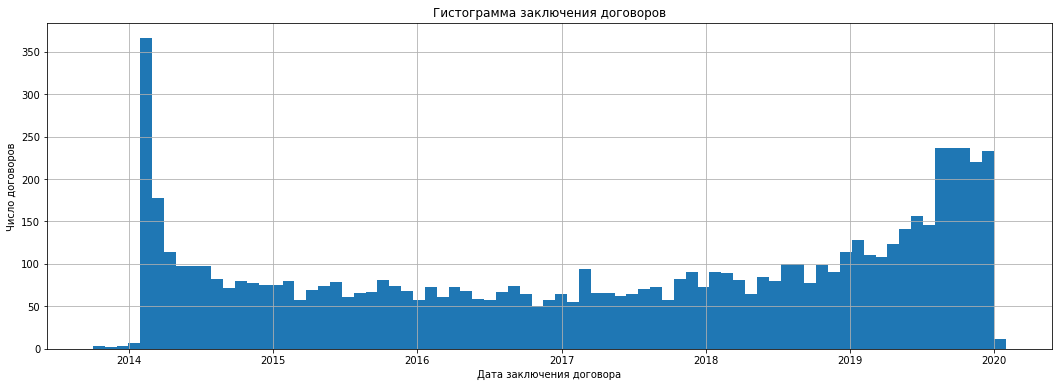

In [35]:
df.begin_date.hist(bins=77, figsize=(18,6))
plt.title('Гистограмма заключения договоров')
plt.ylabel('Число договоров')
plt.xlabel('Дата заключения договора')
plt.show()

Данные представлены за период: с октября 2013 по февраль 2020. Максимальное число заключенных договоров - февраль 2014г (366 шт.). Возможно, тогда компания вышла на рынок. Далее число заключений помесячно снижается. Возобновление активности по заключению договоров началось в 2019г, особенный всплеск начался в сентябре 2019г. (среднемесячное число заключений превысило 200 шт.). Максимальное число заключенных договоров по годам - в 2019г. Наблюдаются колебания в числе заключений догворов по месяцам. Наверняка, это связано с маркетинговой активностью компании.

------------

Посмотрим на динамику расторжения договоров:

In [36]:
print('Дата самого раннего расторжения', contract['end_date'].min())
print('Дата самого позднего расторжения', contract['end_date'].max())

Дата самого раннего расторжения 2019-10-01 00:00:00
Дата самого позднего расторжения 2020-01-01 00:00:00


In [37]:
contract.pivot_table(index='end_date', values='customer_id', aggfunc='count')

,customer_id
end_date,
2019-10-01,458
2019-11-01,485
2019-12-01,466
2020-01-01,460


Построим сводную с данными о расторжении договоров по периодам заключения контрактов.

In [38]:
end = df.pivot_table(index=(df['begin_date'].dt.year), columns=(df['begin_date'].dt.month), 
                     values='exit', aggfunc='sum')
end

begin_date,1,2,3,4,5,6,7,8,9,10,11,12
begin_date,,,,,,,,,,,,
2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.0
2014,7.0,10.0,14.0,6.0,11.0,6.0,10.0,6.0,5.0,4.0,9.0,10.0
2015,7.0,10.0,6.0,13.0,17.0,9.0,6.0,11.0,11.0,9.0,14.0,10.0
2016,6.0,18.0,7.0,11.0,13.0,14.0,8.0,16.0,18.0,14.0,8.0,12.0
2017,14.0,15.0,21.0,13.0,16.0,12.0,16.0,15.0,16.0,12.0,23.0,26.0
2018,17.0,20.0,17.0,18.0,19.0,31.0,26.0,27.0,39.0,26.0,37.0,38.0
2019,43.0,49.0,42.0,37.0,50.0,60.0,76.0,76.0,168.0,144.0,131.0,105.0
2020,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


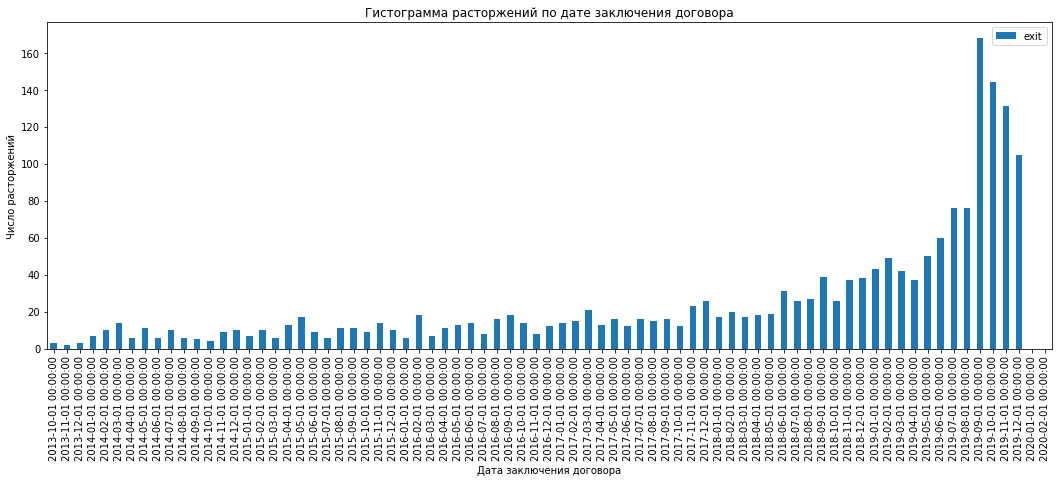

In [39]:
df.pivot_table(index='begin_date', values='exit', 
                     aggfunc='sum').plot.bar(figsize=(18,6))
plt.title('Гистограмма расторжений по дате заключения договора')
plt.ylabel('Число расторжений')
plt.xlabel('Дата заключения договора')
plt.xticks(rotation=90)
plt.show()

Доли расторжений по периодам заключения договоров, в процентах:

In [40]:
(end/begin*100).round()

begin_date,1,2,3,4,5,6,7,8,9,10,11,12
begin_date,,,,,,,,,,,,
2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,100.0
2014,100.0,3.0,8.0,5.0,11.0,6.0,10.0,7.0,7.0,5.0,12.0,13.0
2015,9.0,12.0,10.0,19.0,23.0,11.0,10.0,17.0,16.0,11.0,19.0,15.0
2016,11.0,25.0,11.0,15.0,19.0,24.0,14.0,24.0,24.0,22.0,16.0,21.0
2017,22.0,27.0,22.0,20.0,24.0,19.0,25.0,21.0,22.0,21.0,28.0,29.0
2018,23.0,22.0,19.0,22.0,29.0,37.0,32.0,27.0,39.0,33.0,37.0,42.0
2019,38.0,38.0,38.0,34.0,41.0,43.0,49.0,52.0,71.0,61.0,55.0,48.0
2020,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Получается, что массовые расторжения договоров начались в октябре 2019г: в месяц расторгается 460-480 договоров. Меньше всего расторжений по договорам 2014г (7-10%), больше всего - по договорам 2019г (40-50%).

### 3.2. Портрет клиента

Выгрузим описательную статистику по числовым столбцам:

In [41]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
paperless_billing,7043.0,0.592219,0.491457,0.00,0.00,1.00,1.00,1.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
total_charges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80
senior_citizen,7043.0,0.162147,0.368612,0.00,0.00,0.00,0.00,1.00
partner,7043.0,0.483033,0.499748,0.00,0.00,0.00,1.00,1.00
dependents,7043.0,0.299588,0.458110,0.00,0.00,0.00,1.00,1.00
online_security,7043.0,0.286668,0.452237,0.00,0.00,0.00,1.00,1.00
online_backup,7043.0,0.344881,0.475363,0.00,0.00,0.00,1.00,1.00
device_protection,7043.0,0.343888,0.475038,0.00,0.00,0.00,1.00,1.00
tech_support,7043.0,0.290217,0.453895,0.00,0.00,0.00,1.00,1.00


Изучим распределение клиентов в выборке, построив сводные в различных разрезах.

In [42]:
for col in ['gender', 'senior_citizen', 'partner', 'dependents', 
            'type', 'paperless_billing', 'payment_method', 'internet_service',
            'online_security', 'online_backup', 'device_protection', 'tech_support',
            'streaming_tv', 'streaming_movies', 'multiple_lines']:
    
    print(f'Распределение клиентов по полю {col}, %:')
    display(
        (df.pivot_table(index=col, values='customer_id', 
               aggfunc='count', margins=True, margins_name='Total')/len(df)*100).round(1))

Распределение клиентов по полю gender, %:


,customer_id
gender,
Female,49.5
Male,50.5
Total,100.0


Распределение клиентов по полю senior_citizen, %:


,customer_id
senior_citizen,
0,83.8
1,16.2
Total,100.0


Распределение клиентов по полю partner, %:


,customer_id
partner,
0,51.7
1,48.3
Total,100.0


Распределение клиентов по полю dependents, %:


,customer_id
dependents,
0,70.0
1,30.0
Total,100.0


Распределение клиентов по полю type, %:


,customer_id
type,
Month-to-month,55.0
One year,20.9
Two year,24.1
Total,100.0


Распределение клиентов по полю paperless_billing, %:


,customer_id
paperless_billing,
0,40.8
1,59.2
Total,100.0


Распределение клиентов по полю payment_method, %:


,customer_id
payment_method,
Bank transfer (automatic),21.9
Credit card (automatic),21.6
Electronic check,33.6
Mailed check,22.9
Total,100.0


Распределение клиентов по полю internet_service, %:


,customer_id
internet_service,
DSL,34.4
Fiber optic,44.0
No,21.7
Total,100.0


Распределение клиентов по полю online_security, %:


,customer_id
online_security,
0.0,71.3
1.0,28.7
Total,100.0


Распределение клиентов по полю online_backup, %:


,customer_id
online_backup,
0.0,65.5
1.0,34.5
Total,100.0


Распределение клиентов по полю device_protection, %:


,customer_id
device_protection,
0.0,65.6
1.0,34.4
Total,100.0


Распределение клиентов по полю tech_support, %:


,customer_id
tech_support,
0.0,71.0
1.0,29.0
Total,100.0


Распределение клиентов по полю streaming_tv, %:


,customer_id
streaming_tv,
0.0,61.6
1.0,38.4
Total,100.0


Распределение клиентов по полю streaming_movies, %:


,customer_id
streaming_movies,
0.0,61.2
1.0,38.8
Total,100.0


Распределение клиентов по полю multiple_lines, %:


,customer_id
multiple_lines,
0.0,57.8
1.0,42.2
Total,100.0


В выборке доля ушедших клиентов составляет 26,5%. Средняя продолжительность отношений клиента с компанией = 986 дней (примерно 2 года и 9 месяцев), медиана = 883 дня (примерно 2 года и 5 месяцев). Половина клиентов заключили контракты до 2017 года. 
    
Доля пенсионеров в выборке составляет 16%, доля женатых = 48%, доля имеющих иждевенцев = 30%. В выборке примерно одинаковое количество клиентов женщин и мужчин, а среди них по 16% лиц пенсионного возраста. Доля женатых = 48%. Среди женатых 51% имеют иждивенцев, среди неженатых - лишь 10%.

Среднемесячные траты одного клиента на услуги составляют 65 у.е., медиана = 70 у.е. Медиана выше среднего - значит, есть выбросы слева (клиенты, которые тратят очень мало). 55% клиентов оплачивают услуги раз в месяц, 21% - раз в год, 24% - раз в два года. 

Примерно по 22% клиентов используют для оплаты банковские переводы, кредитные карты, почтовые чеки (. 34% клиентов используют электронные чеки.

Среди клиентов 34% используют DSL подключение, 44% - оптоволоконный кабель, 22% не используют интернет.

Использование различных интернет-услуг, доли клиентов:
- антивирус: 34%
- облачное хранилище: 34%
- блокировка небезопасных сайтов: 29%
- наличие выделенной линии технической поддержки: 29%
- наличие стримингового телевидения: 38%
- наличие услуги Каталог фильмов: 39%
- наличие нескольких телефонных линий: 42%

### 3.3. Портрет ушедшего клиента

Изучим портрет ушедшего клиента, построив сводные в различных разрезах.

In [43]:
for col in ['gender', 'senior_citizen', 'partner', 'dependents', 
            'type', 'paperless_billing', 'payment_method', 'internet_service',
            'online_security', 'online_backup', 'device_protection', 'tech_support',
            'streaming_tv', 'streaming_movies', 'multiple_lines']:
    
    print(f' Доля расторжений по столбцу {col}, %:')
    display((df.pivot_table(index=col, values='exit', aggfunc='mean')*100).round(1))

 Доля расторжений по столбцу gender, %:


,exit
gender,
Female,26.9
Male,26.2


 Доля расторжений по столбцу senior_citizen, %:


,exit
senior_citizen,
0,23.6
1,41.7


 Доля расторжений по столбцу partner, %:


,exit
partner,
0,33.0
1,19.7


 Доля расторжений по столбцу dependents, %:


,exit
dependents,
0,31.3
1,15.5


 Доля расторжений по столбцу type, %:


,exit
type,
Month-to-month,42.7
One year,11.3
Two year,2.8


 Доля расторжений по столбцу paperless_billing, %:


,exit
paperless_billing,
0,16.3
1,33.6


 Доля расторжений по столбцу payment_method, %:


,exit
payment_method,
Bank transfer (automatic),16.7
Credit card (automatic),15.2
Electronic check,45.3
Mailed check,19.1


 Доля расторжений по столбцу internet_service, %:


,exit
internet_service,
DSL,19.0
Fiber optic,41.9
No,7.4


 Доля расторжений по столбцу online_security, %:


,exit
online_security,
0.0,31.3
1.0,14.6


 Доля расторжений по столбцу online_backup, %:


,exit
online_backup,
0.0,29.2
1.0,21.5


 Доля расторжений по столбцу device_protection, %:


,exit
device_protection,
0.0,28.7
1.0,22.5


 Доля расторжений по столбцу tech_support, %:


,exit
tech_support,
0.0,31.2
1.0,15.2


 Доля расторжений по столбцу streaming_tv, %:


,exit
streaming_tv,
0.0,24.3
1.0,30.1


 Доля расторжений по столбцу streaming_movies, %:


,exit
streaming_movies,
0.0,24.4
1.0,29.9


 Доля расторжений по столбцу multiple_lines, %:


,exit
multiple_lines,
0.0,25.0
1.0,28.6


Доля расторжений среди мужчин и женщин почти одинаковые. Скорее всего, этот признак не окажет влияния на целевую переменную.

Клиенты, наиболее склонные к уходу:
- Пенсионеры (расторгают договоры в 2 раза чаще, чем остальные)
- Неженатые (расторгают договоры в 1,5 раза чаще, чем остальные)
- Не имеющие иждивенцев (расторгают договоры в 2 раза чаще, чем остальные)
- Клиенты с помесячной оплатой услуг (доля расторжений 43%). А вот при оплате раз в 2 года расторжений минимальное количество (3%)
- Клиенты с использованием безбумажного выставления счетов (расторгают договоры в 2 раза чаще, чем остальные)
- При использовании электронных чеков (расторгают договоры в 3 раза чаще, чем остальные)
- Клиенты, использующие интернет. При этом имеющие соединение по оптоволокну расторгают договор в 3 раза чаще, чем клиенты с DSL-соединением. А вот клиенты без интернета расторгают лишь 7% договоров.
- Клиенты, которые не использует различные интернет-сервисы.

### 3.4. Анализ корреляций

Проанализируем линейную связь переменных. Выгрузим коэффициент корреляции Пирсона по целевой переменной:

In [44]:
df.corr(method='pearson')['exit']

paperless_billing    0.191825
monthly_charges      0.193356
total_charges       -0.198324
senior_citizen       0.150889
partner             -0.150448
dependents          -0.164221
online_security     -0.171226
online_backup       -0.082255
device_protection   -0.066160
tech_support        -0.164674
streaming_tv         0.063228
streaming_movies     0.061382
multiple_lines       0.040102
exit                 1.000000
duration            -0.352673
Name: exit, dtype: float64

Проверим линейную связь факторов на общих исходных данных. Матрица корреляций будет иметь размер 21х21, ее будет достаточно сложно анализировать. Выведем на экран значения только относительно высоких коэффициентов парной корреляции (более 0.4 по модулю):

In [45]:
f_1=[]  # список для фактора 1
f_2=[]  # список для фактора 2
high_cor=[]  # список для коэффициентов корреляции свыше 0.8
df_1 = df.select_dtypes('number') # датафрейм с числовыми столбцами
for i in range(1,df_1.shape[1]):
    c = df_1.columns
    for j in range(i+1, len(c)):
        b = df_1[c[i]].corr(df_1[c[j]], method='pearson')
        if abs(b)>0.4:          # условие для отбора пар признаков с корреляцией выше 0.8
            f_1.append(c[i])
            f_2.append(c[j])
            high_cor.append(b)

high_corr = pd.DataFrame({'feature_1':f_1, 'feature_2':f_2, 'high_corr':high_cor}) # таблица высокой корреляции
display(high_corr)
print('Число пар признаков с высокой корреляцией:', len(high_corr))

,feature_1,feature_2,high_corr
0,monthly_charges,total_charges,0.651174
1,monthly_charges,online_backup,0.441780
2,monthly_charges,device_protection,0.482692
3,monthly_charges,streaming_tv,0.629603
4,monthly_charges,streaming_movies,0.627429
5,monthly_charges,multiple_lines,0.490434
6,total_charges,online_security,0.411651
7,total_charges,online_backup,0.509226
8,total_charges,device_protection,0.521983
9,total_charges,tech_support,0.431883


Число пар признаков с высокой корреляцией: 17


Сильного влияния на целевую переменную не оказывает ни один из факторов. Обратная линейная зависисмость средней силы (коэф. корреляции = -0.35)наблюдается между целевой переменной и длительностью контракта в днях. 
    
Между факторами есть связь средней силы, в основном, по переменным с тратами на услуги и наличием подключенных услуг - это логично, так как чем больше услуг, тем выше затраты клиента. Есть еще связь между наличием супругов и иждивенцев, что тоже интуитивно понятно. Также есть связь между наличием стримингового ТВ и каталога фильмов, что довольно логично. Менее очевидная связь средней силы между наличием антивируса и наличием стримингового телевидения (коэф. корр. = 0.4).

## 4. Подготовка данных для моделирования

Поля begin_date, end_date нам не нужны, так как есть поле с продолжительностью контракта - удалим их, чтобы избежать утечки целевой переменной. Также удалим поле customer_id.

In [46]:
df = df.drop(['begin_date', 'end_date', 'customer_id'], axis=1)

In [47]:
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exit,duration
0,Month-to-month,1,Electronic check,29.85,29.85,Female,0,1,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,31
1,One year,0,Mailed check,56.95,1889.50,Male,0,0,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1036
2,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,61
3,One year,0,Bank transfer (automatic),42.30,1840.75,Male,0,0,0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,1371
4,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,61


Для начала преобразуем с помощью One-Hot Encoding категориальные признаки в численные:
- type,
- payment_method,
- gender,
- internet_service.

In [48]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,paperless_billing,monthly_charges,total_charges,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exit,duration,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,internet_service_Fiber optic,internet_service_No
0,1,29.85,29.85,0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,31,0,0,0,1,0,0,0,0
1,0,56.95,1889.50,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1036,1,0,0,0,1,1,0,0
2,1,53.85,108.15,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,61,0,0,0,0,1,1,0,0
3,0,42.30,1840.75,0,0,0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,1371,1,0,0,0,0,1,0,0
4,1,70.70,151.65,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,61,0,0,0,1,0,0,1,0


Разделим данные на независимые и зависимую переменные:

In [49]:
x = df.drop(['exit'], axis=1)
y = df['exit']

Разделим выборку на обучающую и тестовую:

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

Проверим размеры выборок:

In [51]:
[sample.shape for sample in [x_train, y_train, x_test, y_test]]

[(5282, 22), (5282,), (1761, 22), (1761,)]

У количественных признаков 'monthly_charges', 'total_charges', 'duration' разный масштаб. Поэтому стандартизируем их с помощью StandardScaler.

In [52]:
numeric = ['monthly_charges', 'total_charges', 'duration'] #список количественных признаков
scaler = StandardScaler()
scaler.fit(x_train[numeric])
x_train[numeric]= scaler.transform(x_train[numeric])
x_test[numeric]= scaler.transform(x_test[numeric])

# первые 5 строк обучающей выборки
x_train.head()

,paperless_billing,monthly_charges,total_charges,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,internet_service_Fiber optic,internet_service_No
3296,1,-0.514314,-0.460284,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.341770,0,0,1,0,0,0,0,0
6397,0,0.017840,0.556508,1,0,0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.884037,1,0,0,0,0,1,0,0
6043,1,-0.819594,-0.948382,0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.197825,0,0,0,0,1,1,0,0
5309,0,-1.483535,-0.440119,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.168049,0,1,1,0,0,0,0,1
3000,1,0.658427,-0.537185,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.830753,0,0,0,1,0,1,1,0


*Выводы*

Признаки для построения модели подготовлены: категориальные переведены в численные, произведено масштабирование количественных признаков. Данные разделены на обучающую (train) и тестовую (test) выборки.

## 5. Построение моделей оттока

Наблюдается дисбаланс классов: доля ушедших клиентов 26,5%. Попробуем достичь заданного качества модели, проигнорировав дисбаланс. Если не получится, будем пробовать методы борьбы с дисбалансом (upsamling, downsampling).

Напишем функцию для определения roc_auc - критерия качества моделей:

In [53]:
scorer = make_scorer(roc_auc_score, greater_is_better=True)

### 5.1. Логистическая регрессия

Обучим модель логистической регрессии:

In [413]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression()

Оценим качество модели:

In [414]:
ra_lr_train = roc_auc_score(y_train, (lr.predict_proba(x_train)[:,1])).round(3)
print('Качество на обучающей выборке:', ra_lr_train)

Качество на обучающей выборке: 0.854


In [415]:
ra_lr = roc_auc_score(y_test, (lr.predict_proba(x_test)[:,1])).round(3)
print('Качество на тестовой выборке:', ra_lr)

Качество на тестовой выборке: 0.83


In [416]:
print('Смещение:', lr.intercept_.round(2))

lr_coef = pd.DataFrame({'Признак': x_train.columns, 
                        'Коэффициент': lr.coef_[0],
              'Модуль коэффициента':[abs(x) for x in lr.coef_[0]]}).sort_values(
    by='Модуль коэффициента', ascending=False).reset_index(drop=True)

print('ТОП-10 признаков с самыми высокими коэффициентами по модулю:')

lr_coef[['Признак','Коэффициент']].head(10)

Смещение: [-2.19]
ТОП-10 признаков с самыми высокими коэффициентами по модулю:


,Признак,Коэффициент
0,duration,-1.436682
1,internet_service_No,-1.359059
2,internet_service_Fiber optic,1.345819
3,type_Two year,-1.328538
4,monthly_charges,-0.755757
5,type_One year,-0.747297
6,total_charges,0.650973
7,streaming_tv,0.502989
8,multiple_lines,0.465955
9,streaming_movies,0.376611


### 5.2. Дерево решений

Построим модель дерева решений. Осуществим подбор параметров для дерева решений с помощью GridSearchCV. Были протестированы различные диапазоны для гиперпараметров. Ниже продемонстрирован подбор в диапазоне, который дал лучший результат.

In [417]:
parametrs_dt = {'max_depth': range(6,9),
               'min_samples_split': range(36,40)}

In [418]:
dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), 
                             param_grid=parametrs_dt, 
                             scoring=scorer, cv=3)
dt.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': range(6, 9),
                         'min_samples_split': range(36, 40)},
             scoring=make_scorer(roc_auc_score))

In [419]:
print('Оптимальная глубина дерева решений:', dt.best_params_.get('max_depth'))
print('Минимальное количество выборок, необходимое для разделения внутреннего узла:', 
      dt.best_params_.get('min_samples_split'))

Оптимальная глубина дерева решений: 8
Минимальное количество выборок, необходимое для разделения внутреннего узла: 37


Гиперпараметры подобраны. Оценим качество модели:

In [420]:
ra_dt_train = roc_auc_score(y_train, (rf.predict_proba(x_train)[:,1])).round(3)
print('Качество на обучающей выборке:', ra_dt_train)
ra_dt = roc_auc_score(y_test, (dt.predict_proba(x_test)[:,1])).round(3)
print('Качество на тестовой выборке:', ra_dt)      

Качество на обучающей выборке: 0.941
Качество на тестовой выборке: 0.841


Продемонстрируем важность признаков:

In [421]:
dt_importances = pd.DataFrame({'Признак': x_train.columns, 
              'Важность признака': dt.best_estimator_.feature_importances_}).sort_values(
    by='Важность признака', ascending=False).reset_index(drop=True)
dt_importances

,Признак,Важность признака
0,duration,0.519146
1,internet_service_Fiber optic,0.236694
2,total_charges,0.071810
3,monthly_charges,0.033070
4,payment_method_Electronic check,0.022826
5,multiple_lines,0.021312
6,internet_service_No,0.020613
7,type_Two year,0.017018
8,type_One year,0.013996
9,tech_support,0.008242


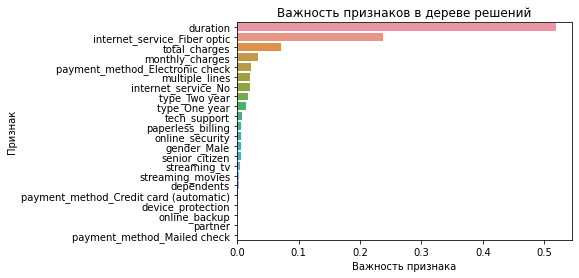

In [422]:
sns.barplot(x=dt_importances['Важность признака'],
            y=dt_importances['Признак'])
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в дереве решений')
plt.show()

- ТОП-3 наиболее значимых признаков: продолжительность контракта в днях, тип подключения интернету, общие расходы клиента.
- Наименее значимые: способы оплаты, наличие антивируса, наличие облачного хранилища файлов, наличие супруга, метод оплаты.

### 5.3. Случайный лес

Параметры будем подбирать с помощью GridSearchCV. Были протестированы различные диапазоны для гиперпараметров. Ниже продемонстрирован подбор в диапазоне, который дал лучший результат.

In [423]:
parametrs_rf = {'max_depth': range(7,11),
               'n_estimators': range(120,136,5)}

In [424]:
rf = GridSearchCV(estimator=RandomForestClassifier(random_state=0, max_features='sqrt'), 
                             param_grid=parametrs_rf, 
                             scoring=scorer, cv=3, n_jobs=-1)

In [425]:
rf.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_features='sqrt',
                                              random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': range(7, 11),
                         'n_estimators': range(120, 136, 5)},
             scoring=make_scorer(roc_auc_score))

In [426]:
print('Оптимальная глубина в модели случайного леса:',
      rf.best_params_.get('max_depth'))
print('Оптимальное число деревьев в модели случайного леса:',
      rf.best_params_.get('n_estimators'))

Оптимальная глубина в модели случайного леса: 9
Оптимальное число деревьев в модели случайного леса: 130


Гиперпараметры подобраны. Оценим качество модели:

In [427]:
ra_rf_train = roc_auc_score(y_train, (rf.predict_proba(x_train)[:,1])).round(3)
print('Качество на обучающей выборке:', ra_rf_train)

ra_rf = roc_auc_score(y_test, (rf.predict_proba(x_test)[:,1])).round(3)
print('Качество на тестовой выборке:', ra_rf)      

Качество на обучающей выборке: 0.941
Качество на тестовой выборке: 0.847


Продемонстрируем важность признаков:

In [428]:
rf_importances = pd.DataFrame({'Признак': x_train.columns, 
              'Важность признака': rf.best_estimator_.feature_importances_}).sort_values(
    by='Важность признака', ascending=False).reset_index(drop=True)
rf_importances

,Признак,Важность признака
0,duration,0.243739
1,total_charges,0.155967
2,monthly_charges,0.118793
3,internet_service_Fiber optic,0.093120
4,type_Two year,0.064296
5,payment_method_Electronic check,0.063827
6,type_One year,0.041991
7,internet_service_No,0.028020
8,online_security,0.024187
9,tech_support,0.019985


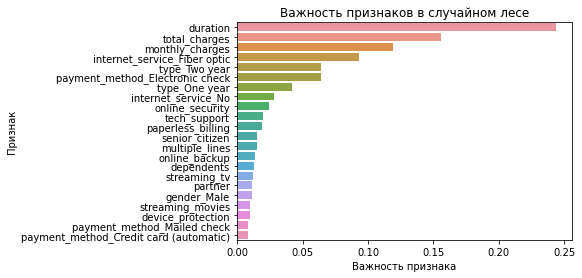

In [429]:
sns.barplot(x=rf_importances['Важность признака'],
            y=rf_importances['Признак'])
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в случайном лесе')
plt.show()

- ТОП-3 наиболее значимых признаков: продолжительность контракта в днях, расходы клиента
- Наименее значимые: способы оплаты, наличие антивируса.

### 5.4. Градиентный бустинг

Построим модель градиентного бустинга:

In [430]:
parametrs_cb = {'learning_rate': [0.05,0.1,0.15]}

In [431]:
cb = GridSearchCV(estimator=CatBoostClassifier(loss_function="Logloss", custom_metric='AUC'), 
                             param_grid=parametrs_cb, 
                             scoring=scorer, cv=3, n_jobs=-1)

In [432]:
cb.fit(x_train, y_train)

0:	learn: 0.6615854	total: 2.18ms	remaining: 2.18s
1:	learn: 0.6347099	total: 4.39ms	remaining: 2.19s
2:	learn: 0.6114834	total: 6.21ms	remaining: 2.06s
3:	learn: 0.5891072	total: 8.06ms	remaining: 2.01s
4:	learn: 0.5696806	total: 9.95ms	remaining: 1.98s
5:	learn: 0.5524296	total: 11.8ms	remaining: 1.96s
6:	learn: 0.5328218	total: 13.8ms	remaining: 1.95s
7:	learn: 0.5177371	total: 15.7ms	remaining: 1.95s
8:	learn: 0.5054031	total: 17.6ms	remaining: 1.93s
9:	learn: 0.4960342	total: 19.4ms	remaining: 1.92s
10:	learn: 0.4831718	total: 21.4ms	remaining: 1.92s
11:	learn: 0.4757152	total: 23.3ms	remaining: 1.92s
12:	learn: 0.4685425	total: 25.1ms	remaining: 1.91s
13:	learn: 0.4616196	total: 27.3ms	remaining: 1.93s
14:	learn: 0.4563153	total: 30.1ms	remaining: 1.98s
15:	learn: 0.4515834	total: 32.7ms	remaining: 2.01s
16:	learn: 0.4450683	total: 35.3ms	remaining: 2.04s
17:	learn: 0.4389103	total: 37.5ms	remaining: 2.04s
18:	learn: 0.4349419	total: 40.6ms	remaining: 2.09s
19:	learn: 0.4312838	t

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f562e38c0d0>,
             n_jobs=-1, param_grid={'learning_rate': [0.05, 0.1, 0.15]},
             scoring=make_scorer(roc_auc_score))

In [433]:
ra_cb_train = roc_auc_score(y_train, (cb.predict_proba(x_train)[:,1])).round(3)
print('Качество на обучающей выборке:', ra_cb_train)

ra_cb = roc_auc_score(y_test, (cb.predict_proba(x_test)[:,1])).round(3)
print('Качество на тестовой выборке:', ra_cb)    

Качество на обучающей выборке: 0.991
Качество на тестовой выборке: 0.9


Продемонстрируем важность признаков:

In [434]:
cb_importances = pd.DataFrame({'Признак': x_train.columns, 
              'Важность признака': cb.best_estimator_.feature_importances_}).sort_values(
    by='Важность признака', ascending=False).reset_index(drop=True)
cb_importances

,Признак,Важность признака
0,duration,42.266119
1,monthly_charges,12.369532
2,total_charges,10.138163
3,type_Two year,4.149108
4,internet_service_Fiber optic,2.977263
5,type_One year,2.434537
6,paperless_billing,2.380499
7,payment_method_Electronic check,2.130107
8,multiple_lines,2.108269
9,dependents,2.093325


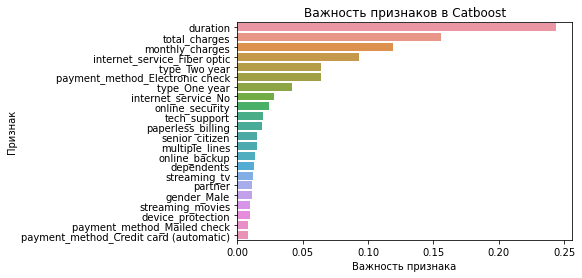

In [435]:
sns.barplot(x=rf_importances['Важность признака'],
            y=rf_importances['Признак'])
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в Catboost')
plt.show()

- ТОП-3 наиболее значимых признаков: продолжительность контракта в днях, расходы клиента.
- Наименее значимые: способы оплаты, наличие антивируса.

## 6. Выбор лучшей модели

Соберем результаты в один датафрейм:

In [436]:
roc_auc = pd.DataFrame({'Model': ['Логистическая регрессия', "Дерево решений",
                                 "Случайный лес", "Градиентный бустинг"],
                    "roc_auc_train": [ra_lr_train, ra_dt_train, ra_rf_train, ra_cb_train],
                    "roc_auc_test":[ra_lr, ra_dt, ra_rf, ra_cb]})
roc_auc

,Model,roc_auc_train,roc_auc_test
0,Логистическая регрессия,0.854,0.830
1,Дерево решений,0.941,0.841
2,Случайный лес,0.941,0.847
3,Градиентный бустинг,0.991,0.900


Лучшее качество достигли на модели градиентного бустинга.
Построим ROC-кривую для тестовой выборки:

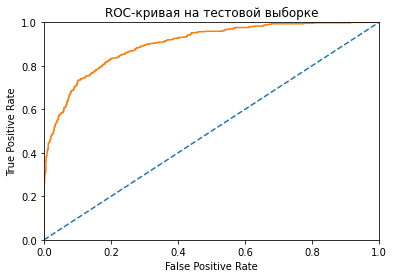

In [437]:
fpr, tpr, thresholds = roc_curve(y_test, 
                                 (cb.predict_proba(x_test)[:,1]))

plt.plot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая на тестовой выборке')
plt.show()

## 7. Общий вывод по проекту

В ходе работы были проанализированы данные по 7 тыс. договорам и клиентам оператора связи «Ниединогоразрыва.ком». 
Данные представлены за период: с октября 2013 по февраль 2020. Максимальное число заключенных договоров в месяц - февраль 2014г. Далее число заключений помесячно снижается. Возобновление активности по заключению договоров началось в 2019г, особенный всплеск начался в сентябре 2019г. (среднемесячное число заключений превысило 200 шт.). Максимальное число заключенных договоров по годам - в 2019г. Массовые расторжения договоров начались в октябре 2019г: в месяц расторгается 460-480 договоров. Меньше всего расторжений по договорам 2014г (7-10%), больше всего - по договорам 2019г (40-50%).

В выборке доля ушедших клиентов составляет 26,5%. Средняя продолжительность отношений клиента с компанией = 986 дней (примерно 2 года и 9 месяцев), медиана = 883 дня (примерно 2 года и 5 месяцев). Половина клиентов заключили контракты до 2017 года. 
    
В ходе работы составлены портреты среднестатистического клиента и портрет клиента, который расторг договор. Клиенты, наиболее склонные к уходу:
- Пенсионеры (расторгают договоры в 2 раза чаще, чем остальные)
- Неженатые (расторгают договоры в 1,5 раза чаще, чем остальные)
- Не имеющие иждивенцев (расторгают договоры в 2 раза чаще, чем остальные)
- Клиенты с помесячной оплатой услуг (доля расторжений 43%). А вот при оплате раз в 2 года расторжений минимальное количество (3%)
- Клиенты с использованием безбумажного выставления счетов (расторгают договоры в 2 раза чаще, чем остальные)
- При использовании электронных чеков (расторгают договоры в 3 раза чаще, чем остальные)
- Клиенты, использующие интернет. При этом имеющие соединение по оптоволокну расторгают договор в 3 раза чаще, чем клиенты с DSL-соединением. А вот клиенты без интернета расторгают лишь 7% договоров.
- Клиенты, которые не использует различные интернет-сервисы.

Произведена предобработка данных, сгенерирован дополнительный признак: продолжительность действия контракта в днях.

Сильного влияния на целевую переменную не оказывает ни один из факторов. Обратная линейная зависисмость средней силы (коэф. корреляции = -0.35) наблюдается между целевой переменной и длительностью контракта в днях.

Были построены 4 типа моделей классификации:
1. Логистическая регрессия
2. Дерево решений
3. Случайный лес
4. Градиентный бустинг

Наилучнее качество по параметру ROC-AUC показала модель бустинга: значение ROC-AUC на тестовой выборке равно 0.9. 
- ТОП-3 наиболее значимых признаков, согласно модели бустинга: продолжительность контракта в днях, расходы клиента в месяц, общие расходы.